### To run neural nets, skip to the last section (no need to run any of the code above it)

In [22]:
import nflgame
import mirofeatures as mf
import morefeatures as mf2
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ftrs2, isPass = mf.getFeatures(2009,2016) #get original feature set using nflgame API

In [169]:
df_ftrs = pd.DataFrame(ftrs2) #Process data into pandas dataframes
df_isPass = pd.DataFrame(isPass)
isPass =np.array(isPass)
df_ftrs.head(10) 
ftrs = np.array(ftrs2)

## Using a simple logistic classifier

To start, we have to drop the categorical features because they don't play well with linear classification. 

In [170]:
X = df_ftrs.drop(['opponent', 'team'], axis = 1) #Drops out opponent and team, cat variables 

We randomly mask our 238,599 data points so that we reserve some for testing the model

In [171]:
np.random.seed(12356) #Randomly seeded mask of the data, 3/4 for training, 1/4 for validation
mask = np.full(len(ftrs), False)
mask[:len(ftrs)*3/4] = True
np.random.shuffle(mask)

Fitting,

In [182]:
clf = linear_model.SGDClassifier(loss='log')
clf.fit(X[mask],isPass[mask])

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [173]:
print("Success rate in predicting pass (for training data) is %f%%" % (100*clf.score(X[mask], isPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*clf.score(X[np.invert(mask)], isPass[np.invert(mask)])))

Success rate in predicting pass (for training data) is 57.097274%
Success rate in predicting pass (for test data) is 57.232188%


In [183]:
mf2.cross_val(clf,X,isPass)

Cross validation accuracy with 10 folds is 0.56 (+/- 0.14)


Before modification: 57% ! Just based on logistic regression. There's also a huge amoung of variance based on what our cut (ie. how we mask the data) is.


In [10]:
np.sum(isPass)/float(len(isPass))

0.57018679877115996

Big surprise! For these seasons, about 57% of all plays are passes, so our naive classifier is only barely better than just always guessing "pass."

Let's compare to a decision tree that Ashwin/Tynan thought up (I know nothing about football so couldn't really help - Miro)

In [96]:
naive2 = [True for i in range(len(isPass))]
for i in range(len(isPass)):
    if df_ftrs['down'][i] == 1 and df_ftrs['togo'][i] <= 5:
        naive2[i] = False
    elif df_ftrs['down'][i] == 2 and df_ftrs['togo'][i] < 6:
        naive2[i] = False
    elif df_ftrs['down'][i] == 3 and df_ftrs['togo'][i] < 3:
        naive2[i] = False
    elif df_ftrs['down'][i] == 4 and df_ftrs['togo'][i] < 2:
        naive2[i] = False

In [97]:
print(np.sum(naive2==isPass)/float(len(isPass)))

0.589436669894


Linear regression just barely outperforms this!

<module 'matplotlib.pyplot' from '/Users/miro/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

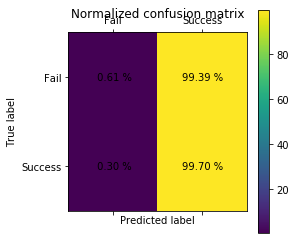

In [31]:
mf2.conf_m(confusion_matrix(isPass[np.invert(mask)], clf.predict(X[np.invert(mask)])))

## Using LDA (Linear Discriminant Analysis)

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [53]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X[mask],isPass[mask])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [35]:
print("Success rate in predicting pass (for training data) is %f%%" % (100*lda_model.score(X[mask], isPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*lda_model.score(X[np.invert(mask)], isPass[np.invert(mask)])))

Success rate in predicting pass (for training data) is 70.746973%
Success rate in predicting pass (for test data) is 70.799665%


In [184]:
mf2.cross_val(lda_model,X,isPass)

Cross validation accuracy with 10 folds is 0.71 (+/- 0.02)


<module 'matplotlib.pyplot' from '/Users/miro/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

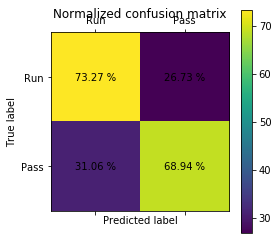

In [37]:
mf2.conf_m(confusion_matrix(isPass[np.invert(mask)], lda_model.predict(X[np.invert(mask)])))

## Using a tree based model

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
rf_model = RandomForestClassifier()
rf_model.fit(X[mask],isPass[mask])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
print("Success rate in predicting pass (for training data) is %f%%" % (100*rf_model.score(X[mask], isPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*rf_model.score(X[np.invert(mask)], isPass[np.invert(mask)])))

Success rate in predicting pass (for training data) is 96.288887%
Success rate in predicting pass (for test data) is 66.546521%


In [185]:
mf2.cross_val(rf_model,X,isPass)

Cross validation accuracy with 10 folds is 0.66 (+/- 0.01)


<module 'matplotlib.pyplot' from '/Users/miro/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

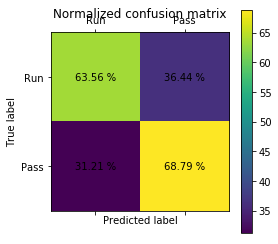

In [46]:
mf2.conf_m(confusion_matrix(isPass[np.invert(mask)], rf_model.predict(X[np.invert(mask)])))

Naively, seems like there is a substantial improvement in predicting play/pass. 66% is not terrible! But 96% training accuracy? Clearly some overfitting is happening here. Let's try dropping out time.


In [55]:
X2 = df_ftrs.drop(['opponent', 'team', 'time'], axis = 1)

In [56]:
rf_model2 = RandomForestClassifier()
rf_model2.fit(X2[mask],isPass[mask])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
print("Success rate in predicting pass (for training data) is %f%%" % (100*rf_model2.score(X2[mask], isPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*rf_model2.score(X2[np.invert(mask)], isPass[np.invert(mask)])))

Success rate in predicting pass (for training data) is 76.202158%
Success rate in predicting pass (for test data) is 69.074602%


In [186]:
mf2.cross_val(rf_model2,X2,isPass)

Cross validation accuracy with 10 folds is 0.69 (+/- 0.01)


<module 'matplotlib.pyplot' from '/Users/miro/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

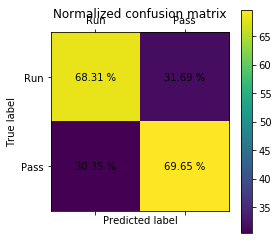

In [59]:
mf2.conf_m(confusion_matrix(isPass[np.invert(mask)], rf_model2.predict(X2[np.invert(mask)])))

Nice! We've increased test accuracy and looks like at least some of the overfitting for training data has been resolved. What if we include team and opponent?

## Expanding our feature set (and also changing data set to be 2002-2012 rather than 2009-2016)

Notebook will have a couple of problems here, because I will repeatedly restart while adding features. Append "n" to the variable names because it's a new dataset. Started with only the features above and have added: point difference,

In [10]:
nftrs2, nisPass = mf2.getAllFeatures() #Feature engineering code restricted to model

/Users/ashwin/python-getting-started/py2virtual/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (10,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


We will drop out the 2002 season so that our team stats can have a good start. Otherwise team pass/run stats would be relying on incomplete data, 

In [147]:
ndf_ftrs = pd.DataFrame(nftrs2)
ndf_isPass = pd.DataFrame(nisPass)
nisPass =np.array(nisPass)

nisPass = nisPass[ndf_ftrs['season']!=2002]
ndf_ftrs = ndf_ftrs[ndf_ftrs['season']!=2002]
ndf_ftrs.head(10)

,down,isHome,last800,lastPlay,opponent,ptdiff,quarter,season,shotgun,team,togo,togoal
33038,1,True,0.53125,0,NYJ,0,1,2003,0,WAS,10,71
33039,2,True,0.53000,0,NYJ,0,1,2003,0,WAS,7,68
33040,3,True,0.52875,0,NYJ,0,1,2003,0,WAS,2,63
33041,1,True,0.52875,0,NYJ,0,1,2003,0,WAS,10,59
33042,2,True,0.52875,1,NYJ,0,1,2003,0,WAS,6,55
33043,3,True,0.52750,0,NYJ,0,1,2003,0,WAS,4,53
33044,2,True,0.52750,1,NYJ,0,1,2003,0,WAS,17,54
33045,1,True,0.52750,1,NYJ,0,1,2003,0,WAS,10,29
33046,2,True,0.52750,1,NYJ,0,1,2003,0,WAS,9,28
33047,4,True,0.52750,1,NYJ,0,1,2003,0,WAS,13,32


In [187]:
nX = ndf_ftrs.drop(['opponent', 'team','togoal','season','last800','lastPlay'], axis = 1)

In [188]:
np.random.seed(123456)
mask = np.full(len(ndf_ftrs), False)
mask[:len(nftrs2)*3/4] = True
np.random.shuffle(mask)
rf_model3 = RandomForestClassifier()
rf_model3.fit(nX[mask],nisPass[mask])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [154]:
print("Success rate in predicting pass (for training data) is %f%%" % (100*rf_model3.score(nX[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*rf_model3.score(nX[np.invert(mask)], nisPass[np.invert(mask)])))

Success rate in predicting pass (for training data) is 73.757695%
Success rate in predicting pass (for test data) is 70.513735%


In [189]:
mf2.cross_val(rf_model3,nX,nisPass)

Cross validation accuracy with 10 folds is 0.70 (+/- 0.08)


<module 'matplotlib.pyplot' from '/Users/miro/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

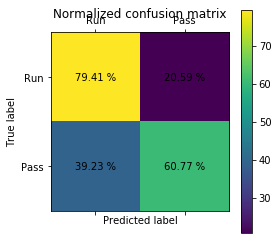

In [155]:
mf2.conf_m(confusion_matrix(nisPass[np.invert(mask)], rf_model3.predict(nX[np.invert(mask)])))

In [136]:
nlda_model = LinearDiscriminantAnalysis()
nlda_model.fit(nX[mask],nisPass[mask])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [137]:
print("Success rate in predicting pass (for training data) is %f%%" % (100*nlda_model.score(nX[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*nlda_model.score(nX[np.invert(mask)], nisPass[np.invert(mask)])))

Success rate in predicting pass (for training data) is 67.911086%
Success rate in predicting pass (for test data) is 68.043530%


In [190]:
mf2.cross_val(nlda_model,nX,nisPass)

Cross validation accuracy with 10 folds is 0.67 (+/- 0.12)


<module 'matplotlib.pyplot' from '/Users/miro/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

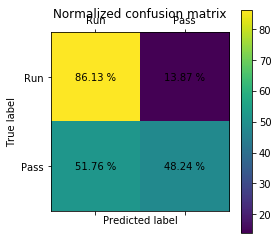

In [138]:
mf2.conf_m(confusion_matrix(nisPass[np.invert(mask)], nlda_model.predict(nX[np.invert(mask)])))

In [139]:
np.sum(nisPass)/float(len(nisPass))

0.47990260516252392

Many more runs in this dataset than the prior one? What gives? It's actually part of a broader trend towards more passing in the NFL. 

<img height=100 width=800 src="https://www.besttickets.com/blog/wp-content/uploads/2013/09/Rushing-Vs-Passing.png"></img>

### Adding team/historical data

In [195]:
X = ndf_ftrs.drop(['opponent', 'team','togoal','season','last800'], axis = 1) #Keep the last 1 play

In [196]:
np.random.seed(216216)
mask = np.full(len(ndf_ftrs), False)
mask[:len(nftrs2)*3/4] = True
np.random.shuffle(mask)
rf4 = RandomForestClassifier()
rf4.fit(X[mask],nisPass[mask])
print("Success rate in predicting pass (for training data) is %f%%" % (100*rf4.score(X[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*rf4.score(X[np.invert(mask)], nisPass[np.invert(mask)])))
mf2.cross_val(rf4,X,nisPass)


Success rate in predicting pass (for training data) is 89.726921%
Success rate in predicting pass (for test data) is 67.656446%
Cross validation accuracy with 10 folds is 0.64 (+/- 0.12)


In [194]:
np.random.seed(216216)
mask = np.full(len(ndf_ftrs), False)
mask[:len(nftrs2)*3/4] = True
np.random.shuffle(mask)
lda3 = LinearDiscriminantAnalysis()
lda3.fit(X[mask],nisPass[mask])
print("Success rate in predicting pass (for training data) is %f%%" % (100*lda3.score(X[mask], nisPass[mask])))
print("Success rate in predicting pass (for test data) is %f%%" % (100*lda3.score(X[np.invert(mask)], nisPass[np.invert(mask)])))
mf2.cross_val(lda3,X,nisPass)

Success rate in predicting pass (for training data) is 67.256669%
Success rate in predicting pass (for test data) is 67.593630%
Cross validation accuracy with 10 folds is 0.67 (+/- 0.11)


### Neural Networks

In [1]:
import newftrs as new_features
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

/Users/ashwin/python-getting-started/py2virtual/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [99]:
downs, togos, togoals, ptdiffs, quarters, shotguns, teams, seasons, isHomes, opponents, isPasses = new_features.get()

In [75]:
inputs = {'downs': downs, 'togos': togos, 'togoals': togoals, 'ptdiffs': ptdiffs, 
          'quarters': quarters, 'shotguns': shotguns, 'teams': teams, 'seasons': seasons,
          'isHomes': isHomes, 'opponents': opponents}

inputlist = np.asarray([downs, togos, togoals, ptdiffs, quarters, shotguns, teams, seasons, isHomes, opponents])
inputlist = np.transpose(inputlist)

In [56]:
print(inputlist.shape)

(10, 367758)


In [52]:
# create model
model = Sequential()
model.add(Dense(6, input_dim=10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
print(len(downs))

367758


In [97]:
# text data mapping

from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence
teams_text = ' '.join(str(word) for word in teams)
opponents_text = ' '.join(str(word) for word in opponents)
teams_mapped = teams_text
opponents_mapped = opponents_text
vocab_size = 32
teams_result = hashing_trick(teams_mapped, vocab_size, hash_function='md5')
opponents_result = hashing_trick(opponents_mapped, vocab_size, hash_function='md5')
print(teams_result[200:220])
print(opponents_result[200:220])

[2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L]
[1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 2L, 2L, 2L, 2L, 2L, 2L, 2L, 2L]


In [76]:
inputlist = np.asarray([downs, togos, togoals, ptdiffs, quarters, shotguns, 
                        teams_result, seasons, isHomes, opponents_result])
inputlist = np.transpose(inputlist)

In [94]:
# Split the data into training and testing data
print(inputlist.shape)
percent_testing = 0.30 # percent of dataset to set aside for testing
split = int(round((1-percent_testing)*inputlist.shape[0]))
print(split)
train_inputs = inputlist[:split, :]
test_inputs = inputlist[split:, :]
train_outputs = isPasses[:split]
test_outputs = isPasses[split:]

(367758, 10)
257431


In [87]:
# Train the model
# CHANGE epochs to 150
model.fit(x=train_inputs, y=train_outputs, epochs=10, batch_size=10)

Epoch 1/10
257431/257431 [==============================] - 30s 118us/step - loss: 7.6623 - acc: 0.51942s - loss: 7.6615 - acc: 0.5 - ETA: 2s - loss: 7.6603 - -
Epoch 2/10
257431/257431 [==============================] - 31s 119us/step - loss: 7.6623 - acc: 0.5194
Epoch 3/10
257431/257431 [==============================] - 30s 116us/step - loss: 7.6623 - acc: 0.51946s - loss - ETA: 5s  - ETA: 4s - loss: 7.6653 - acc: 0 - ETA: 4s - loss: 7.664 - ETA: 3s - loss: 7.6665 - acc: 0.519 - - ETA: 1s -
Epoch 4/10
257431/257431 [==============================] - 30s 117us/step - loss: 7.6623 - acc: 0.5194 - ETA: 0s - loss: 7.6601 -
Epoch 5/10
257431/257431 [==============================] - 30s 117us/step - loss: 7.6623 - acc: 0.51945s - loss: 7.6547 - acc: 0.5 - ETA: - ET
Epoch 6/10
257431/257431 [==============================] - 30s 117us/step - loss: 7.6623 - acc: 0.51949s - loss: 7.6671 - acc: 0.519 - ETA: 9s - loss: 7.667 - ETA: 4s - loss: 7.6674 - a
Epoch 7/10
257431/257431 [=============

In [3]:
# evaluate the model
scores = model.evaluate(test_inputs, test_outputs)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

NameError: name 'model' is not defined

In [86]:
# 3 epochs = 64.78%

In [2]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

/Users/ashwin/python-getting-started/py2virtual/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


NameError: name 'model' is not defined